# Bottom Up Attention with Detectron2
In this notebook, I'm looking to explore how to capture regional features from the Flickr30K dataset using Detectron2. For every image in the dataset, we extract the bounding boxes using a segmentation model, then compute the features in the bounded image.

In [ ]:
# Install Detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [57]:
# Some basic setup:
# Setup detectron2 logger
from collections import defaultdict
import exdir
import torch
import nltk
from copy import copy
from tqdm import tqdm
from torchvision.datasets import Flickr30k
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
\
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.structures.image_list import ImageList
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

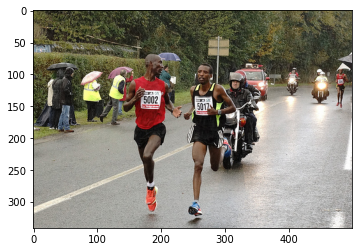

In [45]:
image_path = "/home/jalexbox/Code/school/ece763/class_project/ImageCaptioningProject/flickr30k/flickr30k-images/8154670501.jpg"
im = cv2.imread(image_path)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

In [46]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [47]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([ 0,  0,  3,  0, 25,  3,  0,  3,  0, 25,  0,  0,  0, 25,  0,  0,  2, 25,
        26, 24], device='cuda:0')
Boxes(tensor([[140.5254,  64.9163, 230.8912, 313.3250],
        [239.0271,  82.8132, 318.5885, 322.6801],
        [294.1441, 140.9653, 353.3969, 249.8478],
        [102.9277,  95.0236, 147.1877, 180.1385],
        [ 73.5720,  94.9630, 110.2981, 117.1531],
        [396.6119, 103.9027, 416.6597, 134.0432],
        [472.9462,  93.0537, 496.1903, 151.3156],
        [435.8174, 109.4122, 463.9496, 146.6457],
        [304.2226, 100.2188, 351.6644, 213.8505],
        [117.0887,  87.8889, 157.4307, 109.4578],
        [ 78.0208, 107.2573, 107.8682, 175.3802],
        [ 39.1504,  89.1277,  68.9683, 187.5696],
        [ 23.5371,  87.1252,  48.4150, 188.0245],
        [196.3943,  66.2982, 232.5876,  81.7623],
        [397.8534,  90.6870, 418.8956, 122.9897],
        [436.4175,  92.2951, 464.1935, 135.8965],
        [316.1897,  90.2991, 369.8562, 140.9197],
        [ 21.1289,  82.4478,  

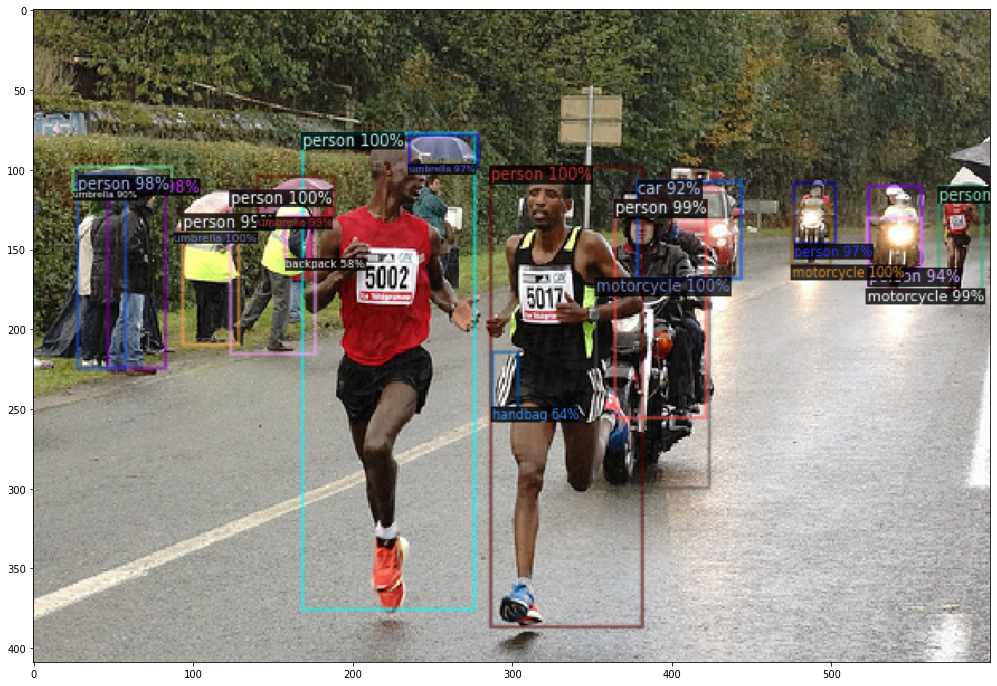

In [48]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(20,12))
plt.imshow(out.get_image()[:, :, ::-1])

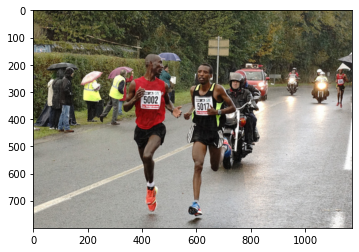

torch.Size([1, 3, 800, 1184])
torch.Size([20, 1024])


In [49]:
height, width = im.shape[:2]
img = predictor.aug.get_transform(im).apply_image(im)
plt.imshow(img)
plt.show()
img = torch.as_tensor(img.astype("float32").transpose(2,0,1))
images = ImageList.from_tensors([img])
inputs = [{"image":img, "height": height, "width":width}]
with torch.no_grad():
    data = predictor.model.preprocess_image(inputs)
    print(data.tensor.size())
    features = predictor.model.backbone(data.tensor)
    proposals, _ = predictor.model.proposal_generator(data, features, None)

    proposal_boxes = [x.proposal_boxes for x in proposals]
    features_list = [features[f] for f in predictor.model.roi_heads.in_features]
    proposal_rois = predictor.model.roi_heads.box_pooler(features_list,  proposal_boxes)
    region_features = predictor.model.roi_heads.box_head(proposal_rois)  
    predictions = predictor.model.roi_heads.box_predictor(region_features)
    preds, pred_ind = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
    preds = predictor.model.roi_heads.forward_with_given_boxes(features, preds)
    
    preds = predictor.model._postprocess(preds, inputs, images.image_sizes)
    feats = region_features[pred_ind]
print(feats.size())

In [54]:
# set up data
base_path = "/home/jalexbox/Code/school/ece763/class_project/ImageCaptioningProject/flickr30k/flickr30k-images"
ann_path = "/home/jalexbox/Code/school/ece763/class_project/ImageCaptioningProject/flickr30k/results_20130124.token"
torch_dataset = Flickr30k(base_path, ann_path)

In [55]:
# create dataset 
dataset_path = "/home/jalexbox/Code/school/ece763/class_project/ImageCaptioningProject/flickr30k"
archive = exdir.File(dataset_path)
train_archive = archive.require_group("train")
valid_archive = archive.require_group("valid")
test_archive = archive.require_group("test")

img_ids = torch_dataset.ids
train_ids = img_ids[: int(len(img_ids) * 0.8)]
val_ids = img_ids[int(len(img_ids) * 0.8) : int(len(img_ids) * 0.8) + int(len(img_ids) * 0.15)]
test_ids = img_ids[int(len(img_ids) * 0.8) + int(len(img_ids) * 0.15) :]
train_captions = defaultdict(list)
val_captions = defaultdict(list)
test_captions = defaultdict(list)

print(f"# Train Examples {len(train_ids)}")
print(f"# Validation Examples {len(val_ids)}")
print(f"# Test examples {len(test_ids)}")

# Train Examples 25426
# Validation Examples 4767
# Test examples 1590


In [61]:
words = defaultdict(lambda: 0)
max_caption_length = 0
for i, img_id in enumerate(tqdm(img_ids, desc="Loading Data")):
    image, captions = torch_dataset[i]
    image = np.asarray(image)
    if img_id in train_ids:
        store = train_archive
        cap_store = train_captions
    elif img_id in val_ids:
        store = valid_archive
        cap_store = val_captions
    else:
        store = test_archive
        cap_store = test_captions
    image_group = store.require_group(img_id)
    for cap in captions:
        cap_store[img_id].append(cap)
        tokens = nltk.tokenize.word_tokenize(cap.lower())
        if len(tokens) > max_caption_length:
            max_caption_length = len(tokens)
        for toke in tokens:
            words[toke] += 1
            
    height, width = image.shape[:2]
    img = predictor.aug.get_transform(image).apply_image(image)
    img = torch.as_tensor(img.astype("float32").transpose(2,0,1))
    images = ImageList.from_tensors([img])
    inputs = [{"image":img, "height": height, "width":width}]
    with torch.no_grad():
        data = predictor.model.preprocess_image(inputs)
        features = predictor.model.backbone(data.tensor)
        proposals, _ = predictor.model.proposal_generator(data, features, None)

        proposal_boxes = [x.proposal_boxes for x in proposals]
        features_list = [features[f] for f in predictor.model.roi_heads.in_features]
        proposal_rois = predictor.model.roi_heads.box_pooler(features_list,  proposal_boxes)
        region_features = predictor.model.roi_heads.box_head(proposal_rois)  
        predictions = predictor.model.roi_heads.box_predictor(region_features)
        preds, pred_ind = predictor.model.roi_heads.box_predictor.inference(predictions, proposals)
        preds = predictor.model.roi_heads.forward_with_given_boxes(features, preds)
        
        preds = predictor.model._postprocess(preds, inputs, images.image_sizes)
        feats = region_features[pred_ind]      
    image_data = image_group.require_dataset("image", data=image)
    feature_data = image_group.require_dataset("features", data=features["p2"].cpu().numpy())
    region_data = image_group.require_dataset("region_features", data=feats)

max_caption_length += 2  # take start and end token into account

Loading Data:   0%|          | 0/31783 [00:00<?, ?it/s]


TypeError: Cannot interpret 'torch.float32' as a data type

In [ ]:
# build token-map
word_freqs = [(k, v) for k, v in words.items()]
word_freqs.sort(key=lambda x: x[1], reverse=True)
topk = word_freqs[:8000]  # We select top K words to be the model's vocabulary
topk = [w for w, _ in topk]  # only care about the words
token_map = {token: i + 4 for i, token in enumerate(topk)}
token_map["<start>"] = 0
token_map["<end>"] = 1
token_map["<unc>"] = 2
token_map["<pad>"] = 3

# store tokens for dataset
for img_id in tqdm(img_ids, desc="Processing Captions"):
    if img_id in train_ids:
        store = train_archive
        cap_store = train_captions
    elif img_id in val_ids:
        store = valid_archive
        cap_store = val_captions
    else:
        store = test_archive
        cap_store = test_captions
    tokenized_captions = []
    lengths = []
    for cap in cap_store[img_id]:
        tokens = nltk.tokenize.word_tokenize(cap.lower())
        lengths.append(len(tokens))
        # replace uncommon words
        res = copy.copy(tokens)
        for i, toke in enumerate(tokens):
            if toke not in token_map.keys():
                res[i] = token_map["<unc>"]
            else:
                res[i] = token_map[toke]
        res.append(token_map["<end>"])
        res.insert(0, token_map["<start>"])

        # ensure equal length for all captions
        while len(res) < max_caption_length:
            res.append(token_map["<pad>"])
        tokenized_captions.append(res)

    # store caption
    store[img_id].attrs["captions"] = tokenized_captions
    store[img_id].attrs["lengths"] = lengths
archive.attrs["word_map"] = token_map
archive.attrs["max_cap_len"] = max_caption_length